In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

import warnings
warnings.filterwarnings('ignore')

drive_path = '/content/drive/MyDrive/Kuliah/Tugas Akhir/Final Project Shared Folder'
data_path = "Dataset/Data Versioning/"
model_path = "Model/ML Model/"
data_version = "Trained_Oversampled-2.csv"
base_url = "https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?CycleBeginYear=2017"
dataset_names = ['Demographics', 'Dietary', 'Examination', 'Laboratory', 'Questionnaire']

Mounted at /content/drive


In [2]:

df_raw = pd.read_csv(os.path.join(drive_path, data_path+data_version), index_col = 0)
try:
  df_raw = df_raw.set_index('SEQN', drop=True)
  df_raw = df_raw.drop(columns = "Unnamed: 0")
except:
  pass

df_raw.head()

,Dieta1_DRDINT,Dieta1_DR1TFIBE,Quest21_SLQ300,Quest19_PAD660,Quest19_PAQ635,Dieta1_DR1TCHOL,Quest19_PAQ655,Dieta1_DR1TSFAT,Dieta1_DR1TKCAL,Exami2_BMXBMI,...,Quest1_ALQ111,Quest10_ECQ020,Quest16_MCQ220,Quest4_CBD121,Quest16_MCQ366A,Labor2_URDFLOW1,Demog1_DMDEDUC,Quest9_DLQ050,Quest20_PFQ061C,Quest16_MCQ160B
0,1,0,2,2,2.0,0,2,1,0,2,...,1.0,9.0,2.0,7.500000e+01,2.0,1.204,2.0,2.0,1.0,0
1,1,2,2,2,2.0,0,2,1,0,0,...,2.0,9.0,2.0,5.397605e-79,2.0,0.500,1.0,2.0,2.0,0
2,0,2,2,1,2.0,2,1,2,1,3,...,9.0,9.0,2.0,4.000000e+01,2.0,0.107,4.0,1.0,9.0,0
3,1,3,1,0,1.0,3,3,3,3,0,...,1.0,9.0,2.0,8.570000e+02,2.0,0.605,5.0,2.0,9.0,0
4,1,1,2,1,1.0,1,2,3,2,0,...,1.0,9.0,2.0,4.000000e+01,2.0,0.706,3.0,2.0,1.0,0


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def prep_data(df):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

  scaler = StandardScaler()
  X_train.iloc[:, 28:] = scaler.fit_transform(X_train.iloc[:, 28:])
  X_val.iloc[:, 28:] = scaler.transform(X_val.iloc[:, 28:])

  X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
  X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

  print("Train: ", X_train.shape, " ", y_train.shape)
  print("Val: ", X_val.shape, " ", y_val.shape)
  print("Column Used: ", X.columns.tolist())

  return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = prep_data(df_raw)
input_shape = X_train.shape[1:]

print(y_train.value_counts())
print(y_val.value_counts())

Train:  (7515, 85, 1)   (7515,)
Val:  (3221, 85, 1)   (3221,)
Column Used:  ['Dieta1_DRDINT', 'Dieta1_DR1TFIBE', 'Quest21_SLQ300', 'Quest19_PAD660', 'Quest19_PAQ635', 'Dieta1_DR1TCHOL', 'Quest19_PAQ655', 'Dieta1_DR1TSFAT', 'Dieta1_DR1TKCAL', 'Exami2_BMXBMI', 'Dieta1_DR1TSUGR', 'Quest21_SLQ320', 'Quest21_SLQ330', 'Quest19_PAD615', 'Quest21_SLD012', 'Quest21_SLD013', 'Dieta1_DR1DAY', 'Quest6_DED120', 'Quest19_PAQ610', 'Quest6_DED125', 'Dieta1_DR1TPROT', 'Quest19_PAQ640', 'Dieta1_DR1TPFAT', 'Dieta1_DR1TMFAT', 'Dieta1_DR1TCALC', 'Dieta1_DR1TCARB', 'Dieta1_DR1TTFAT', 'Quest19_PAD645', 'Exami1_BPXPLS', 'Demog1_RIDRETH3', 'Demog1_DMDHHSZA', 'Demog1_DMDHHSZE', 'Quest14_INQ020', 'Quest18_OCQ210', 'Demog1_INDIN2', 'Quest12_HEQ030', 'Quest22_SMQ900', 'Exami2_BMXHT', 'Quest3_CDQ009', 'Quest3_CDQ010', 'Exami2_BMXWT', 'Quest3_CDQ008', 'Quest20_PFQ061H', 'Quest7_DIQ010', 'Quest20_PFQ061B', 'Labor1_LBDTCSI', 'Quest17_DPQ040', 'Demog1_RIAGENDR', 'Labor2_URDTIME1', 'Quest22_SMQ890', 'Demog1_DMDMARTL', '

In [23]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=()):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data
        self.logs = {}

    def on_epoch_end(self, epoch, logs={}):
        if not self.validation_data:
            raise RuntimeError("Requires validation_data.")
        if self.logs.get('roc_auc', None) == None:
          self.logs['roc_auc'] = []
        if self.logs.get('f1score', None) == None:
          self.logs['f1score'] = []

        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val, verbose=0)

        # Convert one-hot encoded labels to class labels
        y_pred = np.argmax(y_pred, axis=1)

        # Compute Metrics score
        roc_auc = roc_auc_score(y_val, y_pred, average='weighted')
        f1score = f1_score(y_val, y_pred, average='weighted')

        # Add Metrics score to logs
        self.logs['roc_auc'].append(roc_auc)
        self.logs['f1score'].append(f1score)

In [9]:
def build_model():
  model = models.Sequential()
  model.add(layers.Input(input_shape))
  model.add(layers.Conv1D(filters=8, kernel_size=3, activation='relu'))
  model.add(layers.Conv1D(filters=12, kernel_size=3, activation='relu'))
  model.add(layers.Conv1D(filters=16, kernel_size=3, activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(units=4, activation='relu'))
  model.add(layers.Dense(units=16, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))

  # Compile the model
  model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

  return model


# Summarize Model

In [24]:
model = build_model()

model.summary()

X_train, X_val, y_train, y_val = prep_data(df_raw)


metrics_callback = MetricsCallback(validation_data=(X_val, y_val))
train_metrics_callback = MetricsCallback(validation_data=(X_train, y_train))

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[metrics_callback, train_metrics_callback])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 83, 8)             32        
                                                                 
 conv1d_10 (Conv1D)          (None, 81, 12)            300       
                                                                 
 conv1d_11 (Conv1D)          (None, 79, 16)            592       
                                                                 
 flatten_3 (Flatten)         (None, 1264)              0         
                                                                 
 dense_9 (Dense)             (None, 4)                 5060      
                                                                 
 dense_10 (Dense)            (None, 16)                80        
                                                                 
 dense_11 (Dense)            (None, 2)                

In [25]:
from sklearn.metrics import confusion_matrix

# Evaluate Model

loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
f1score = metrics_callback.logs.get('f1score')[0]
auc = metrics_callback.logs.get('roc_auc')[0]

train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
train_f1score = train_metrics_callback.logs.get('f1score')[0]
train_auc = train_metrics_callback.logs.get('roc_auc')[0]

print("Training Loss: " + str(train_loss*100) + "%")
print("Training Accuracy: " + str(train_accuracy*100) + "%")
print("Training F1 Score: " + str((train_f1score)*100) + "%")
print("Training AUC: " + str(train_auc*100) + "%")

print()
print("Loss: " + str(loss*100) + "%")
print("Accuracy: " + str(accuracy*100) + "%")
print("F1 Score: " + str(f1score*100) + "%")
print("AUC: " + str(auc*100) + "%")

print()
print(confusion_matrix(y_val, np.argmax(model.predict(X_val), axis=1)))

Training Loss: 2.8314808383584023%
Training Accuracy: 98.94877076148987%
Training F1 Score: 94.64938926865528%
Training AUC: 94.64161051653961%

Loss: 12.83319890499115%
Accuracy: 96.58491015434265%
F1 Score: 94.90870410611372%
AUC: 94.91521044285247%

101/101 [==============================] - 0s 2ms/step
[[1563   74]
 [  36 1548]]


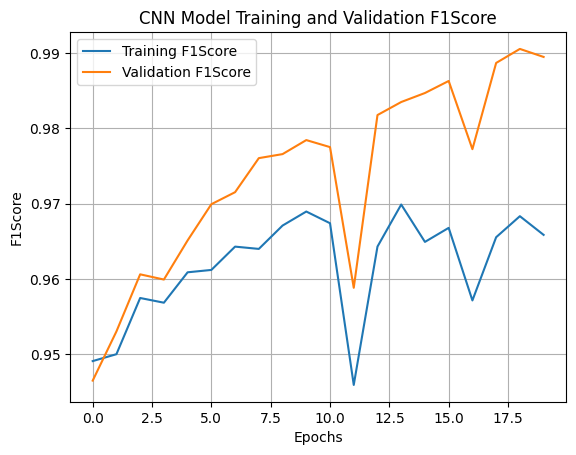

In [26]:
import matplotlib.pyplot as plt

plt.plot(metrics_callback.logs.get('f1score'), label='Training F1Score')
plt.plot(train_metrics_callback.logs.get('f1score'), label='Validation F1Score')
plt.xlabel('Epochs')
plt.ylabel('F1Score')
plt.title('CNN Model Training and Validation F1Score')
plt.legend()
plt.grid(True)
plt.show()

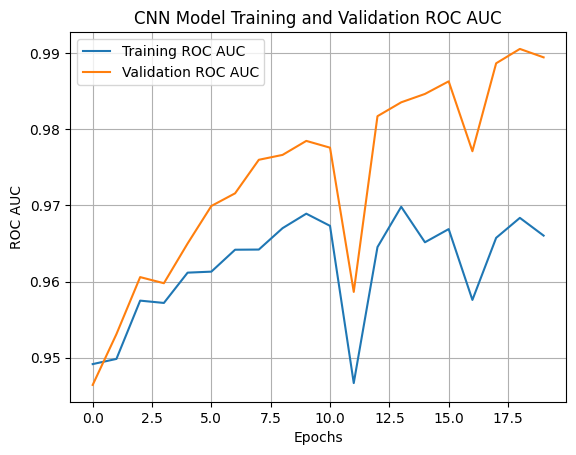

In [27]:
import matplotlib.pyplot as plt

plt.plot(metrics_callback.logs.get('roc_auc'), label='Training ROC AUC')
plt.plot(train_metrics_callback.logs.get('roc_auc'), label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.title('CNN Model Training and Validation ROC AUC')
plt.legend()
plt.grid(True)
plt.show()

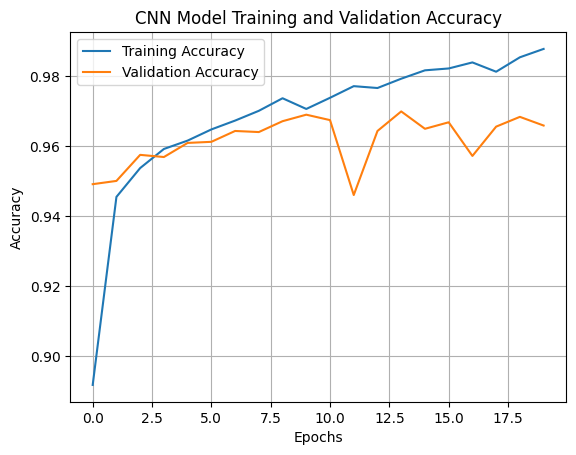

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

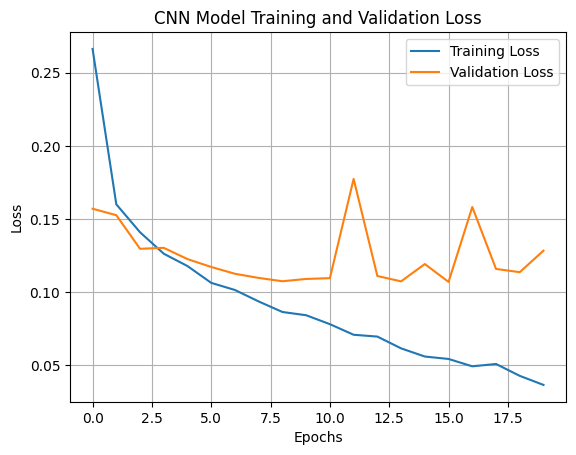

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
model.save(os.path.join(drive_path, model_path+'model_cnn_naive.h5'), save_format='h5')